In [1]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

Using TensorFlow backend.


In [2]:
# configuration
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 100  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [3]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

In [4]:
# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('hin.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 2831


In [5]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [6]:
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 2392 unique input tokens.


In [7]:
# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

In [8]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [9]:
# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

Found 3143 unique output tokens.


In [10]:
# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

In [11]:
# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)

In [12]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (2831, 22)
encoder_inputs[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1276]
decoder_inputs[0]: [   2 1492    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (2831, 26)


In [13]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [14]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [15]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

In [16]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros((len(input_texts), max_len_target, num_words_output), dtype='float32')
#x = np.zeros((len(df), window_length, n_features), dtype='float32')
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [17]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
encoder_outputs, h, c = encoder(x)
# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# decoder_outputs, _ = decoder_gru(
#   decoder_inputs_x,
#   initial_state=encoder_states
# )

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 2264 samples, validate on 567 samples
Epoch 1/100
2264/2264 [==============================] - 32s 14ms/step - loss: 2.4497 - acc: 0.7144 - val_loss: 3.2364 - val_acc: 0.5828
Epoch 2/100
2264/2264 [==============================] - 27s 12ms/step - loss: 1.5854 - acc: 0.7526 - val_loss: 2.6780 - val_acc: 0.6114
Epoch 3/100
2264/2264 [==============================] - 29s 13ms/step - loss: 1.4703 - acc: 0.7742 - val_loss: 2.6800 - val_acc: 0.6256
Epoch 4/100
2264/2264 [==============================] - 29s 13ms/step - loss: 1.3955 - acc: 0.7806 - val_loss: 2.6345 - val_acc: 0.6307
Epoch 5/100
2264/2264 [==============================] - 24s 11ms/step - loss: 1.3296 - acc: 0.7872 - val_loss: 2.6409 - val_acc: 0.6367
Epoch 6/100
2264/2264 [==============================] - 25s 11ms/step - loss: 1.2690 - acc: 0.7933 - val_loss: 2.6418 - val_acc: 0.6401
Epoch

2264/2264 [==============================] - 35s 15ms/step - loss: 0.0205 - acc: 0.9951 - val_loss: 2.9679 - val_acc: 0.6610
Epoch 57/100
2264/2264 [==============================] - 35s 15ms/step - loss: 0.0191 - acc: 0.9952 - val_loss: 2.9588 - val_acc: 0.6629
Epoch 58/100
2264/2264 [==============================] - 34s 15ms/step - loss: 0.0181 - acc: 0.9953 - val_loss: 2.9687 - val_acc: 0.6625
Epoch 59/100
2264/2264 [==============================] - 35s 15ms/step - loss: 0.0172 - acc: 0.9951 - val_loss: 2.9957 - val_acc: 0.6618
Epoch 60/100
2264/2264 [==============================] - 32s 14ms/step - loss: 0.0162 - acc: 0.9950 - val_loss: 3.0050 - val_acc: 0.6631
Epoch 61/100
2264/2264 [==============================] - 25s 11ms/step - loss: 0.0153 - acc: 0.9953 - val_loss: 3.0063 - val_acc: 0.6635
Epoch 62/100
2264/2264 [==============================] - 25s 11ms/step - loss: 0.0146 - acc: 0.9955 - val_loss: 3.0512 - val_acc: 0.6635
Epoch 63/100
2264/2264 [=======================

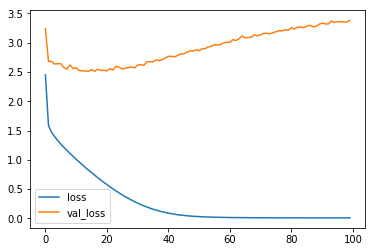

In [19]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

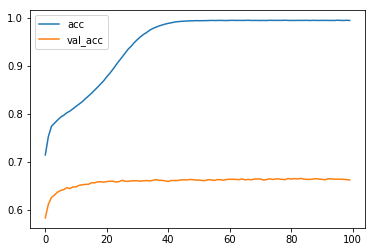

In [20]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [21]:
# Save model
model.save('s2s.h5')

/home/shadaab17/anaconda3/lib/python3.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [22]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [23]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [24]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: When she was reading the letter, she looked sad.
Translation: वह पूरी रात वह किताब थी।
Continue? [Y/n]Y
-
Input: It is said that he is sick.
Translation: कहा जाता है कि वह बीमार है।
Continue? [Y/n]Y
-
Input: The patient breathed his last.
Translation: रोगी ने अपनी आखरी साँस भरी।
Continue? [Y/n]Y
-
Input: He doesn't live in my neighborhood.
Translation: वह मेरे आस-पड़ोस में नहीं रहता।
Continue? [Y/n]Y
-
Input: I admit my mistake.
Translation: मैं अपनी ग़लती मानता हूँ।
Continue? [Y/n]Y
-
Input: I'll let you know when it has been decided.
Translation: मुझे पता में समय क्या किया है।
Continue? [Y/n]Y
-
Input: Remove your shirt and lie down.
Translation: अपनी कमीज़ उतार कर लेट जाओ।
Continue? [Y/n]Y
-
Input: I'll be in Tokyo on business next week.
Translation: मैं अगले हफ़्ते टोक्यो में हूँगा काम पर।
Continue? [Y/n]Y
-
Input: Put it where you like.
Translation: जहाँ भी रखना है रखदो।
Continue? [Y/n]Y
-
Input: I'll make a phone call.
Translation: मैं फ़ोन करता हूँ।
Continue? [Y/n]Y
-
I